In [1]:
import TADcalling
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import cooler

/home/dmitry/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


DEBUG:matplotlib:CACHEDIR=/home/dmitry/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/dmitry/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
TADcalling.set_verbosity('INFO')

### Testing InteractionMatrix

In [3]:
cool_file = '../data/S2.20000.cool'
mtx = cooler.Cooler(cool_file).matrix(balance=True, as_pixels=False).fetch('chr2L')

In [4]:
mtxObj = TADcalling.InteractionMatrix(mtx)

INFO:TADcalling:NaNs filling with 0.00
INFO:TADcalling:Removing 1 first diagonals
INFO:TADcalling:Percentile filtering of input mtx, min percentile: 1.000000 (0.000), max percentile: 99.000000 (0.025)
INFO:TADcalling:Log-transform of input mtx, base: 2
INFO:TADcalling:Subtracting minimum from mtx
INFO:TADcalling:Converting matrix to integer
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


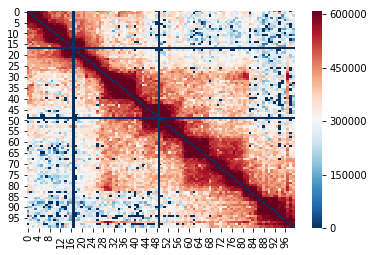

In [5]:
tmp = mtxObj.fill_nans(0).remove_diagonal(1, 0).filter_extreme().log_transform(2)\
    .subtract_min().convert_to_int().as_array() #.delete_bins( np.nansum(mtx, axis=1)<=1 ) 
sns.heatmap(tmp[0:100,0:100], cmap='RdBu_r')

### Testing segmentation running

In [6]:
lc = TADcalling.LavaburstCaller(['S2'], ['../data/S2.20000.cool'], 'cool', assembly='dm3', resolution=20000, balance=True, chr='chr2L')

In [7]:
lc.call({'gamma':np.arange(0,6,0.5), 'method':['armatus', 'modularity']}, max_intertad_size=2)

INFO:TADcalling:NaNs filling with 0.00
INFO:TADcalling:Removing 1 first diagonals
INFO:TADcalling:Percentile filtering of input mtx, min percentile: 1.000000 (0.000), max percentile: 99.000000 (0.025)
INFO:TADcalling:Log-transform of input mtx, base: 2
INFO:TADcalling:Subtracting minimum from mtx


In [8]:
df = lc.segmentation2df()

In [9]:
tads = df.query("method=='armatus'&abs(gamma-1.5)<0.05")[['bgn', 'end']].values

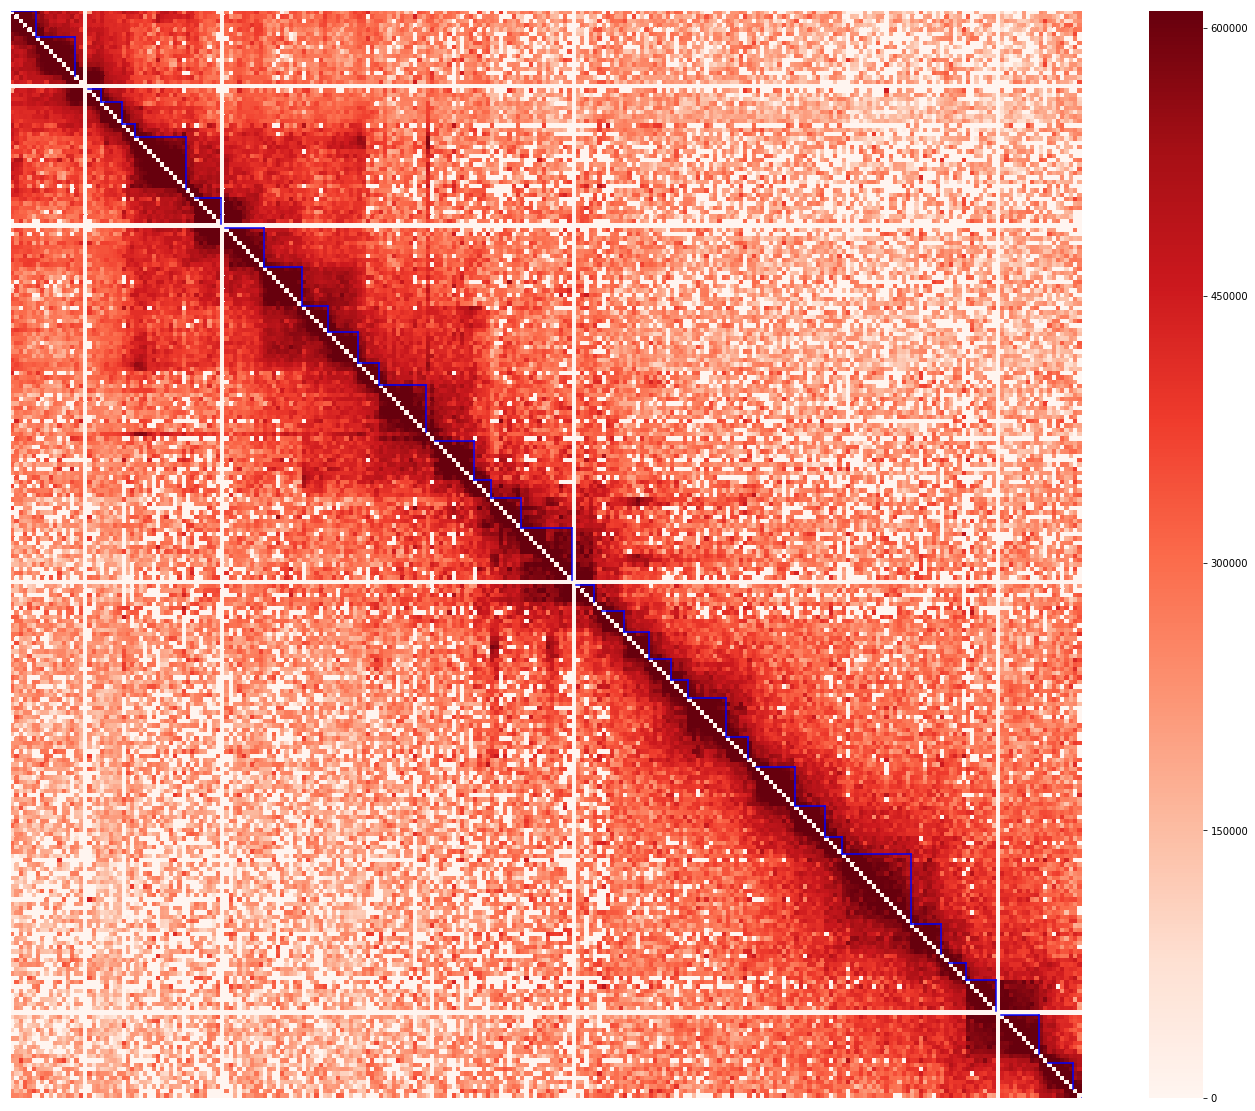

In [10]:
bgn = 0
end = 250
tads_color = 'blue'

# plot tuning
plt.figure(figsize=(24,20))
sns.heatmap(tmp[bgn:end, bgn:end], cmap='Reds')
plt.xticks([])
plt.yticks([])

for i in tads:
    tad_bgn = i[0] - bgn
    tad_end = i[1] - bgn
    plt.plot([tad_bgn, tad_end], [tad_bgn, tad_bgn], color=tads_color)
    plt.plot([tad_end, tad_end], [tad_bgn, tad_end], color=tads_color)

### Testing writing from numpy array to various formats

In [13]:
binsize = lc._metadata['resolution']
assembly = lc._metadata['assembly']
ch = lc._metadata['chr']

chromsizes = cooler.util.fetch_chromsizes(assembly, name_patterns=(r'^chr[0-9]+$', r'^chr[0-9][R,L]+$', r'^chr[XY]$', r'^chrM$') ).loc[ch:ch]
bins = cooler.binnify(chromsizes, binsize)

In [14]:
pixels = cooler.io.ArrayLoader(bins, tmp, chunksize=10000000)
cooler.io.create('./tmp_out.20kb.cool', 
                 bins, 
                 pixels, 
                 assembly=assembly)

INFO:cooler:Creating cooler at "./tmp_out.20kb.cool::/"
INFO:cooler:Writing chroms
INFO:cooler:Writing bins
INFO:cooler:Writing pixels
DEBUG:cooler:writing chunk 0
INFO:cooler:Writing indexes
INFO:cooler:Writing info
INFO:cooler:Done


In [15]:
pixels.array[0:5, 0:5]

array([[     0, 609921, 609921, 609921, 609921],
       [609921,      0, 609921, 609921, 609921],
       [609921, 609921,      0, 609921, 609921],
       [609921, 609921, 609921,      0, 609921],
       [609921, 609921, 609921, 609921,      0]])

In [16]:
cool_file_tmp = './tmp_out.20kb.cool'
mtx_tmp = cooler.Cooler(cool_file_tmp).matrix(balance=False, as_pixels=False).fetch('chr2L')

In [17]:
mtx_tmp[0:5, 0:5]

array([[     0, 609921, 609921, 609921, 609921],
       [609921,      0, 609921, 609921, 609921],
       [609921, 609921,      0, 609921, 609921],
       [609921, 609921, 609921,      0, 609921],
       [609921, 609921, 609921, 609921,      0]], dtype=int32)

### Testing format conversions

In [31]:
import TADcalling

In [ ]:
IS = TADcalling.CallerClasses.InsulationCaller(['S2'], ['../data/S2.20000.cool'], 'cool', assembly='dm3', resolution=20000, balance=True, chr='chr2L')
IS.convert_files('hic', juicer_path='../juicer_tools.1.8.9_jcuda.0.8.jar', remove_intermediary_files=False)

In [33]:
IS.convert_files('h5')